In [1]:
import boto3
import pandas as pd
from io import StringIO

bucket = "ai-bmi-predictor"
key = "data/body_measurements.csv"

s3 = boto3.client("s3")
obj = s3.get_object(Bucket=bucket, Key=key)
body = obj["Body"].read().decode("utf-8")

merged = pd.read_csv(StringIO(body))

print(merged.head())


                                    subject_id      ankle  arm-length  \
0  -494U-YoXOD8e8gkCuyaRLn4MLo5P8Dm2B1s59WBGdg  24.343954   52.902378   
1  -5OHO2b5mRDY1rvAf07sYYtekEEX7ViEGmvRr7l4tfc  22.001783   46.763233   
2  -5iHTazqnmWBsnUY6ymoCw1kORMymRDaUla1eNOjgvI  26.565006   53.288597   
3  -60o95b9oEE83BDV3GpsAVPA4TFvxuPPqtXEY5PApy8  24.779566   49.077751   
4  -67TrwlJ3GSsqPeHaa2Nb0iQ-BKZfIx4ERysQPZ0-SY  20.788853   42.229557   

       bicep       calf       chest    forearm         hip  leg-length  \
0  33.294395  38.709511  102.526024  27.599094  108.047134   81.736435   
1  28.288971  35.649963   99.253395  24.813375   92.128685   75.127258   
2  30.800959  39.854950  102.391273  27.719795  106.044121   84.055527   
3  34.613113  38.104267  111.164070  28.550409  109.529465   74.310234   
4  24.527142  29.181356   93.627777  21.979038   87.134102   67.269859   

   shoulder-breadth  shoulder-to-crotch      thigh       waist      wrist  \
0         35.915691           67.891273

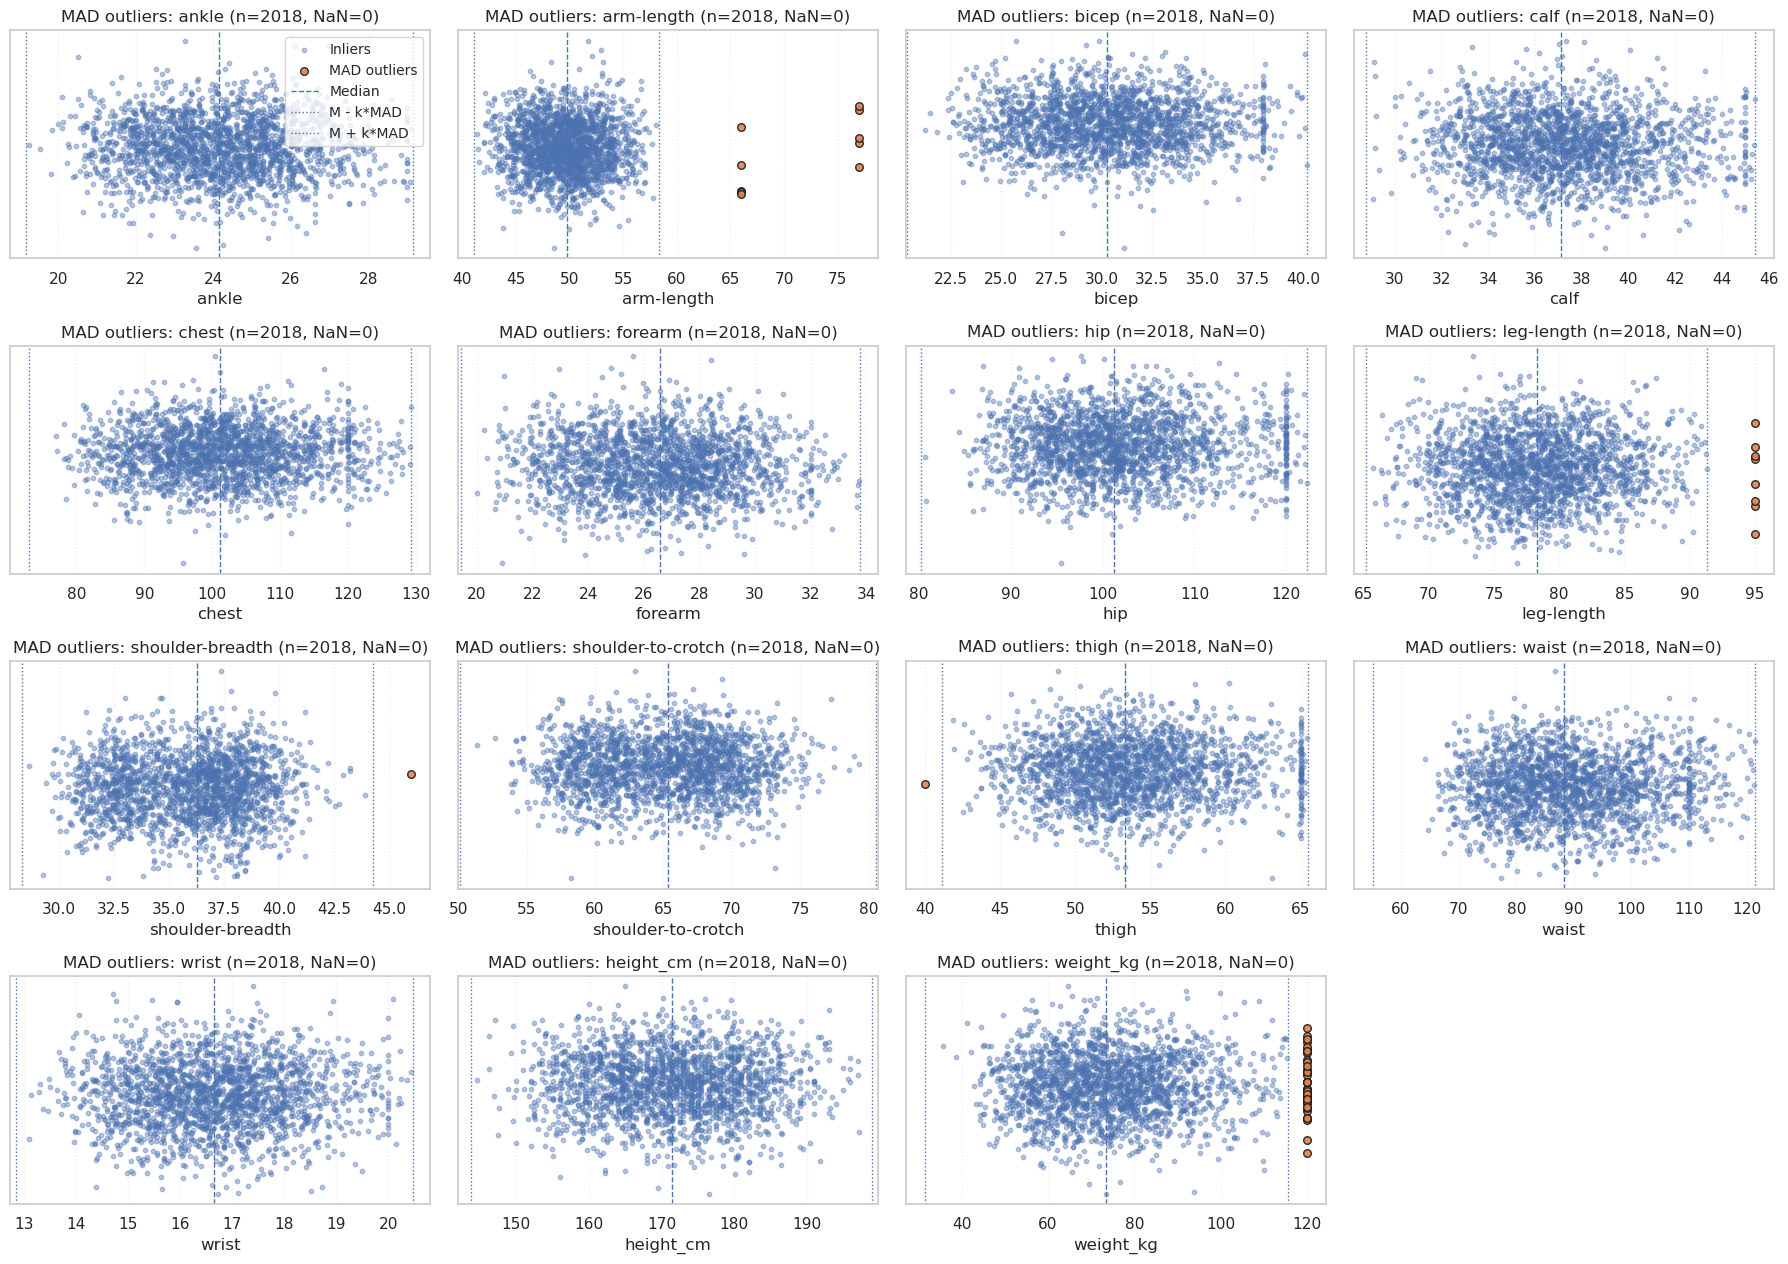

In [2]:
import math                          # for computing rows if you ever change the grid width
import numpy as np                   # to help flatten axes arrays
import pandas as pd                  # for numeric coercion / NA handling
import matplotlib.pyplot as plt      # plotting
import seaborn as sns                # optional: for general style

sns.set(style="whitegrid")

# --- your columns from the merged dataset ---
cols = [
    'ankle', 'arm-length', 'bicep', 'calf', 'chest',
    'forearm', 'hip', 'leg-length', 'shoulder-breadth',
    'shoulder-to-crotch', 'thigh', 'waist', 'wrist',
    'height_cm', 'weight_kg'
]

# keep only columns that actually exist in `merged`
cols = [c for c in cols if c in merged.columns]

if not cols:
    raise ValueError("None of the requested columns exist in 'merged'.")

# --- layout: 4 plots per row ---
plots_per_row = 4
n = len(cols)
nrows = math.ceil(n / plots_per_row)
ncols = plots_per_row

# --- MAD tuning parameter (k) ---
k = 4  # as requested

# dictionary to store outlier indices per column
mad_outliers = {}

# --- create figure & axes ---
fig, axes = plt.subplots(nrows, ncols, figsize=(4.5 * ncols, 3.2 * nrows))
axes = np.atleast_1d(axes).ravel()  # flatten to 1D list of axes

# --- MAD-based outlier detection and plotting ---
for i, col in enumerate(cols):
    # coerce to numeric (non-numeric -> NaN)
    s = pd.to_numeric(merged[col], errors='coerce')
    non_na = s.dropna()             # remove NaNs for analysis
    ax = axes[i]

    if len(non_na) >= 1:
        # 1) Median of the data
        M = non_na.median()

        # 2) Absolute deviations from the median
        abs_dev = (non_na - M).abs()

        # 3) MAD = median of absolute deviations
        MAD = abs_dev.median()

        # 4) Outlier thresholds: M - k*MAD, M + k*MAD
        lower = M - k * MAD
        upper = M + k * MAD

        # 5) Identify inliers and outliers (based on MAD)
        mask_outlier = (non_na < lower) | (non_na > upper)
        outliers = non_na[mask_outlier]
        inliers = non_na[~mask_outlier]

        # Save outlier indices (these are indices in `merged`)
        mad_outliers[col] = list(outliers.index)

        # --- plotting ---
        # Jitter on y for visualization so points don't overlap perfectly
        y_inliers = np.random.normal(loc=0.0, scale=0.02, size=len(inliers))
        y_outliers = np.random.normal(loc=0.0, scale=0.02, size=len(outliers))

        # Plot inliers
        ax.scatter(inliers, y_inliers, alpha=0.4, s=10, label="Inliers")

        # Plot MAD outliers
        ax.scatter(outliers, y_outliers, alpha=0.9, s=30,
                   edgecolor='k', label="MAD outliers")

        # Draw reference lines: median and MAD thresholds
        ax.axvline(M, linestyle='--', linewidth=1, label='Median')
        if MAD > 0:
            ax.axvline(lower, linestyle=':', linewidth=1, label='M - k*MAD')
            ax.axvline(upper, linestyle=':', linewidth=1, label='M + k*MAD')

        # We only care about the x-axis, so hide y-axis
        ax.set_yticks([])

    else:
        ax.text(0.5, 0.5, "No numeric data",
                ha='center', va='center', transform=ax.transAxes)
        mad_outliers[col] = []

    ax.set_title(f"MAD outliers: {col} (n={len(non_na)}, NaN={s.isna().sum()})")
    ax.set_xlabel(col)
    ax.grid(True, axis='x', linestyle=':', alpha=0.35)

    # Only show legend on the first subplot to avoid clutter
    if i == 0:
        ax.legend(loc='upper right', fontsize='small')

# --- remove any unused axes if grid > number of columns ---
for j in range(len(cols), nrows * ncols):
    fig.delaxes(axes[j])

plt.tight_layout()
#plt.savefig("mad_outliers.png", dpi=300, bbox_inches="tight")
plt.show()

# `mad_outliers` now holds the index positions of MAD-based outliers for each column
